In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/Shareddrives/RESM_Project/DEFINITIVO RESM/")

In [ ]:
pip install pvlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 41.6 MB/s eta 0:00:00


In [ ]:
pip install openpyxl


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import numpy as np
from random import *
import pprint
from PIL import Image
from matplotlib import pyplot as plt
from pvlib import *
import pandas as pd
import math
import openpyxl

#Detection of possible fault in the solar panels

è stata rilevata una anomalia nel pannello, 3 immagini presentano la stessa potenziale anomalia: 2


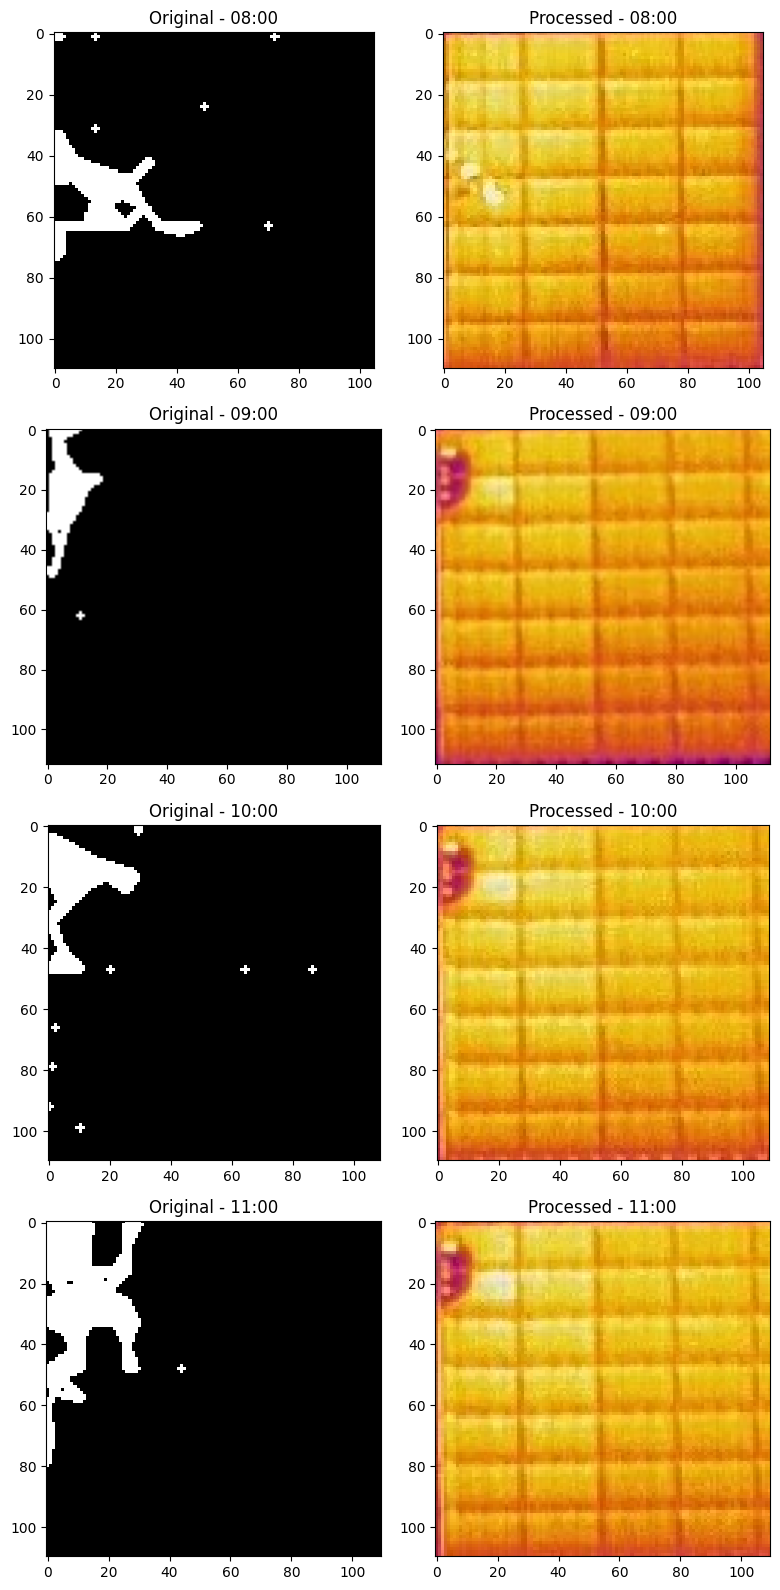

In [ ]:
import numpy as np
import cv2
import datetime
import matplotlib.pyplot as plt

def canny(image, low_threshold, high_threshold):
    # Converti l'immagine in scala di grigi
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Applica il filtro di Gauss per ridurre il rumore
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Calcola i gradienti utilizzando operatori di Sobel
    gradient_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    # Calcola la magnitudo e l'angolo dei gradienti
    magnitude = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
    angle = np.arctan2(gradient_y, gradient_x) * 180 / np.pi

    # Applica una non-maximum suppression
    suppressed = np.zeros_like(magnitude)
    for i in range(1, magnitude.shape[0] - 1):
        for j in range(1, magnitude.shape[1] - 1):
            if (angle[i,j] <= 22.5 and angle[i,j] > -22.5) or (angle[i,j] <= -157.5 or angle[i,j] > 157.5):
                if magnitude[i,j] >= magnitude[i,j-1] and magnitude[i,j] >= magnitude[i,j+1]:
                    suppressed[i,j] = magnitude[i,j]
            elif (angle[i,j] > 22.5 and angle[i,j] <= 67.5) or (angle[i,j] > -157.5 and angle[i,j] <= -112.5):
                if magnitude[i,j] >= magnitude[i-1,j-1] and magnitude[i,j] >= magnitude[i+1,j+1]:
                    suppressed[i,j] = magnitude[i,j]
            elif (angle[i,j] > 67.5 and angle[i,j] <= 112.5) or (angle[i,j] > -112.5 and angle[i,j] <= -67.5):
                if magnitude[i,j] >= magnitude[i-1,j] and magnitude[i,j] >= magnitude[i+1,j]:
                    suppressed[i,j] = magnitude[i,j]
            elif (angle[i,j] > 112.5 and angle[i,j] <= 157.5) or (angle[i,j] > -67.5 and angle[i,j] <= -22.5):
                if magnitude[i,j] >= magnitude[i-1,j+1] and magnitude[i,j] >= magnitude[i+1,j-1]:
                    suppressed[i,j] = magnitude[i,j]
        # Applica isteresi per selezionare i bordi forti
    strong_edges = (suppressed > high_threshold)

    # Identifica i bordi deboli che potrebbero essere bordi forti
    potential_edges = (suppressed >= low_threshold) & (suppressed <= high_threshold)

    # Cerca i bordi forti nelle vicinanze dei bordi deboli
    final_edges = np.zeros_like(strong_edges)
    for i in range(1, final_edges.shape[0] - 1):
        for j in range(1, final_edges.shape[1] - 1):
            if strong_edges[i,j]:
                final_edges[i,j] = True
            elif potential_edges[i,j]:
                if (strong_edges[i-1:i+2,j-1:j+2]).any():
                    final_edges[i,j] = True

    # Restituisci i bordi finali
    return final_edges.astype(np.uint8) * 255

def find_closed_edges(edges):
    # Esegue la trasformata di Hough per individuare le linee
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=5, minLineLength=2, maxLineGap=2)

    if lines is None:
        return []  # Nessuna linea trovata
    # Calcola l'intersezione tra le linee
    intersections = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        for other_line in lines:
            x3, y3, x4, y4 = other_line[0]
            intersection = compute_intersection(x1, y1, x2, y2, x3, y3, x4, y4)
            if intersection is not None:
                intersections.append(intersection)

    # Trova le chiusure tra le linee
    closed_edges = []
    for i, intersection in enumerate(intersections):
        for j in range(i+1, len(intersections)):
            other_intersection = intersections[j]
            distance = np.linalg.norm(intersection - other_intersection)
            if distance < 10:  # Soglia per considerare le linee vicine come chiuse
                closed_edges.append((intersection, other_intersection))

    # Restituisce gli edge chiusi
    return closed_edges

def compute_intersection(x1, y1, x2, y2, x3, y3, x4, y4):
    # Calcola l'intersezione tra due linee
    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denominator == 0:
        return None  # Le linee sono parallele
    x = ((x1*y2 - y1*x2) * (x3 - x4) - (x1 - x2) * (x3*y4 - y3*x4)) / denominator
    y = ((x1*y2 - y1*x2) * (y3 - y4) - (y1 - y2) * (x3*y4 - y3*x4)) / denominator
    return np.array([x, y], dtype=np.int32)


def find_anomaly(path):
    # Carica l'immagine
    image = cv2.imread(path)

    # Applica l'algoritmo di Canny per rilevare gli edge
    edges = cv2.Canny(image, 300, 400)

    # Trova gli edge chiusi
    closed_edges = find_closed_edges(edges)

    # Ottenere la forma dell'immagine
    height, width, channels = image.shape

    # Crea un'immagine nera utilizzando la funzione np.zeros()
    black_image = np.zeros((height, width, 3), dtype=np.uint8)

    for edge in closed_edges:
        cv2.line(black_image, tuple(edge[0]), tuple(edge[1]), (255, 255, 255), 2)
    return black_image

# Definisci la lista di immagini con le rispettive ore del giorno
image_list = [
    {"image": "./ANALISI GUASTI/faults/original (3).jpg", "time": "08:00"},
    {"image": "./ANALISI GUASTI/faults/original (7).jpg", "time": "09:00"},
    {"image": "./ANALISI GUASTI/faults/original (8).jpg", "time": "10:00"},
    {"image": "./ANALISI GUASTI/faults/original (9).jpg", "time": "11:00"},
]

# Creazione della figura per le immagini
fig, axes = plt.subplots(len(image_list), 2, figsize=(8, 16))

# Crea una lista per conservare le immagini processate
processed_images = []

# Contatore per il numero di immagini con il 5% o più di pixel bianchi nella maschera risultante
counter = 0

# Elabora ogni immagine e stampa l'immagine risultante con titolo
for i, image_data in enumerate(image_list):
    path = image_data["image"]
    time = image_data["time"]

    # Carica l'immagine
    original_image = cv2.imread(path)

    # Chiama la funzione find_anomaly per trovare l'anomalia
    processed_image = find_anomaly(path)

    # Ottieni la data e l'ora corrente
    current_datetime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # Aggiungi la data e l'ora all'immagine come titolo
    title = f"{current_datetime} - {time}"

    # Aggiungi l'immagine processata alla lista
    processed_images.append(processed_image)

    # Aggiungi l'immagine elaborata alla figura
    axes[i, 0].imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title("Original - " + time)

    # Aggiungi l'immagine elaborata alla figura
    axes[i, 1].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title("Processed - " + time)

    # Effettua l'AND tra le ultime due maschere binarie se la lunghezza della lista è maggiore di uno
    if len(processed_images) > 1:
        last_mask = processed_images[-2]
        current_mask = processed_images[-1]

        # Assicurati che le dimensioni delle maschere siano uguali
        if last_mask.shape[:2] != current_mask.shape[:2]:
            current_mask = cv2.resize(current_mask, (last_mask.shape[1], last_mask.shape[0]))

        combined_mask = cv2.bitwise_and(last_mask, current_mask)
        # cv2.imshow("Combined Mask", combined_mask)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

        # Calcola la percentuale di pixel bianchi nella maschera risultante
        white_pixels = np.sum(combined_mask == 255)
        total_pixels = combined_mask.shape[0] * combined_mask.shape[1]
        white_pixel_percentage = white_pixels / total_pixels * 100

        # Controlla se la maschera ha almeno il 5% di pixel bianchi
        if white_pixel_percentage >= 5:
            counter += 1
        else:
            counter = 0

# Stampa il valore del contatore
if counter == 2:
    print("è stata rilevata una anomalia nel pannello, 3 immagini presentano la stessa potenziale anomalia:", counter)

# Mostra la figura con tutte le immagini
plt.tight_layout()
plt.show()


#Detection, localization and percentage of shadowing on solar panels


In [ ]:
#PRE-PROCESSING PROPOSTO:
#-IMMAGINE RGB
#-IMMAGINE HSV
#-FIRST_MASK: STARTING FROM THE HSV IMAGE FILTER FOR VALUES OF V
#-SECOND_MASK: STARTING FROM THE RGB IMAGE, CONVERT IT INTO GREYSCALE AND FILTER FOR PIXELS VALUES
#-AND OF TWO MASKS: THE AND OF FIRST MASK AND SECOND MASK
#-DILATE IMAGE: STARTING FROM THE AND OF THE FIRST MASK APPLY A DILATATION

#creeeremo un folder per ciascuna immagine contenente tutto il preprocessing effettuato


In [ ]:
def detection_of_shadowing(source_img, fig):

  source_path = "/content/drive/Shareddrives/RESM_Project/DEFINITIVO RESM/ANALISI ZONE D'OMBRA/DATASET/Images_perspective/"
  dest_path = "/content/drive/Shareddrives/RESM_Project/DEFINITIVO RESM/ANALISI ZONE D'OMBRA/ELABORATED_IMAGES/"


  # setting values to rows and column variables
  rows = 3
  columns = 2

  folder_name = source_img.split(".")[0]
  os.makedirs(dest_path + folder_name, exist_ok=True)
  dest_path = dest_path + folder_name + "/"
  print(dest_path)

  #READ THE IMAGE
  img = cv2.imread(source_path + source_img, cv2.IMREAD_COLOR)
  print("source_path + source_img: ",source_path + source_img)
  img_copy = img.copy()
  cv2.imwrite(dest_path + source_img, img)
  # Adds a subplot at the 1st position
  fig.add_subplot(rows, columns, 1)
  # showing image
  plt.imshow(img)
  plt.axis('off')
  plt.title("Original image")


  #CONVERT THE IMAGE IN THE HSV SPACE
  hsv_image = cv2.cvtColor(img_copy,cv2.COLOR_BGR2HSV)
  cv2.imwrite(dest_path + "hsv_image" + source_img, hsv_image)
  # Adds a subplot at the 2nd position
  fig.add_subplot(rows, columns, 2)
  # showing image
  plt.imshow(hsv_image)
  plt.axis('off')
  plt.title("HSV image")


  #OBTAIN FIRTS MASK
  #FILTERING USING THE VALUE OF V THAT MEANS
  #TO FILTER THE PIXEL THAT ARE MORE OR LESS BRIGTHER,
  #LOW VALUE MEANS LESS BRIGHT AND VICEVERSA
  lower_shadow = np.array([0, 0, 0])
  upper_shadow = np.array([180, 255, 110])
  mask = cv2.inRange(hsv_image, lower_shadow, upper_shadow)
  cv2.imwrite(dest_path + "first_binary_mask" + source_img, mask)
  # Adds a subplot at the 3rd position
  fig.add_subplot(rows, columns, 3)
  # showing image
  plt.imshow(mask)
  plt.axis('off')
  plt.title("First mask")


  #OBTAIN SECOND MASK
  #HERE WE FILTER IN THE STARTING IMAGE(RGB) TO SELECT
  #ONLY THE PIXELS THAT HAVE VALUE LIKE GREY AND WHITE,
  #IN THIS WAY WE PROBABLY OBTAIN A MASK THAT IS
  #COMPLEMENTARY WITH THE PREVIOUS ALREADY GENERATED
  # upload the image
  img = Image.open(dest_path + source_img)
  # convert the image in grey scale
  gray_img = img.convert('L')
  # apply the threshold to pixels value
  threshold = 200
  binary_img = gray_img.point(lambda x: 255 if x > threshold else 0, '1')
  # save the obtained mask
  binary_img.save(dest_path + "second_binary_mask" + source_img)
  # Adds a subplot at the 4th position
  fig.add_subplot(rows, columns, 4)
  # showing image
  plt.imshow(binary_img)
  plt.axis('off')
  plt.title("Second mask")


  #AFTER OBTAINING THE MASK NOW WE DO THE AND BETWEEN
  #THEM IN ORDER TO OBTAIN WHITE PIXELS ONLY FOR
  #THE PIXELS THAT ARE WHITE IN BOTH IMAGES, THAT
  #WILL BE SUNNY PIXELS
  #upload the two masks
  img1 = Image.open(dest_path + "first_binary_mask" + source_img).convert("1")
  img2 = Image.open(dest_path + "second_binary_mask" + source_img).convert("1")
  #check that the dimensions are the same
  if img1.size != img2.size:
      raise ValueError("Le due immagini devono avere le stesse dimensioni")
  #create a new empty image
  new_img = Image.new("1", img1.size)
  #iterate over each pixels of the image
  for x in range(img1.size[0]):
      for y in range(img1.size[1]):
          #if both images have white pixel set it as white also in the new image
          if img1.getpixel((x, y)) == 0 and img2.getpixel((x, y)) == 0:
              new_img.putpixel((x, y), 1)
  #save resulting image
  new_img.save(dest_path + "result_binary_image" + source_img)
  # Adds a subplot at the 5th position
  fig.add_subplot(rows, columns, 5)
  # showing image
  plt.imshow(new_img)
  plt.axis('off')
  plt.title("AND of two masks")

  #APPLICHIAMO LA DILATAZIONE
  def_cropped_img = cv2.imread(dest_path + 'result_binary_image' + source_img)
  morfological_kernel = np.ones((5,5), np.uint8)
  dilate_image = cv2.dilate(def_cropped_img, morfological_kernel)
  cv2.imwrite(dest_path + "dilate" + source_img,dilate_image)
  fig.add_subplot(rows, columns, 6)
  # showing image
  plt.imshow(dilate_image)
  plt.axis('off')
  plt.title("Dilate and of the two masks")


  #APPLICHIAMO DILATAZIONE ALLA SECOND BINARY MASK questa serve per delle computazioni da fare dopo
  img2 = cv2.imread(dest_path + 'second_binary_mask' + source_img)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  morfological_kernel = np.ones((5,5), np.uint8)
  dilate_image2 = cv2.dilate(img2, morfological_kernel)
  cv2.imwrite(dest_path + "second_mask_dilate" + source_img,dilate_image2)




##Compute percentage and position of shadowing

In [ ]:
#Alla fine della elaborazione come si vede: la parte bianca contiene dei pixel neri che sono però quelli strutturali del pannello piu alcuni che sono realmente di ombreggiatura
#quindi bisogna mettere un lower bound tale per cui se i pixel neri sono solo quelli strutturali e quindi sono al di sotto di una certa percentuale
#quella sezione di pannello viene considerata completamente al sole. Per tale threshold metterei almeno il 7%

#discorso analogo vale nel caso delle colonne 3 e 4 in cui ci sono pixel bianchi che sono solo strutturali del pannello, quindi al di sotto di quella soglia bisogna assumere che il pannello
#sia completamente posto all'ombra.

In [ ]:
#calcoliamo la percentuale di pixel bianchi su ciascuna striscia del pannello:
#la prima striscia va fino a 149
#la seconda va fino a 298
#la terza va fino a 445
#la quarta va fino alla fine 600

def compute_sun_percentage_for_slice(image, source_img):
    structural_mask = Image.open("./ANALISI ZONE D'OMBRA/ELABORATED_IMAGES/"+ source_img.split(".")[0] + "/second_mask_dilate" + source_img)
    structural_mask = structural_mask.convert("L")
    number = {1:0,2:0,3:0,4:0} #numero di pixel soleggiati contenuti in ciascuna sezione
    width, height = image.size
    total_pixels = width * height
    white_pixels = 0
    print("width of the image: ",width, "height of the image: ",height)
    # Scansiona ogni pixel dell'immagine
    for x in range(width):
        for y in range(height):
            if(x<=149):
                num = 1
            elif(x<=298):
                num = 2
            elif(x<=445):
                num = 3
            elif(x<=600):
                num = 4
            pixel_value = image.getpixel((x, y))
            structural_pixel = structural_mask.getpixel((x, y))
            if pixel_value >=100 and structural_pixel<100:  # Valore massimo per un pixel bianco e controllo che non sia un bianco perchè strutturale
              number[num] +=1 #andiamo a incrementare la specifica colonna di riferimento
    return number


In [ ]:
def compute_structural_percentage(source_img):
  number_structural_slice = {1:0,2:0,3:0,4:0}
  path_immagine ="./ANALISI ZONE D'OMBRA/ELABORATED_IMAGES/"+ source_img.split(".")[0] + "/second_mask_dilate" + source_img
  image = Image.open(path_immagine)
  image = image.convert("L")
  for x in range(image.width):
      for y in range(image.height):
          if(x<=149):
              num = 1
          elif(x<=298):
              num = 2
          elif(x<=445):
              num = 3
          elif(x<=600):
              num = 4
          pixel_value = image.getpixel((x, y))
          if pixel_value >=100:
            number_structural_slice[num] +=1
  return number_structural_slice

In [ ]:
#COMPUTE PERCENTAGE AND POSITION OF SHADOWING FOR THE COMPLETE PANEL

def compute_total_sun_percentage(source_img):
  slice_dim = {1:149, 2:149 , 3:147, 4:155} #sono i valore di pixel in colonna a cui termina ciascuna sezione del pannello
  # # Esempio di utilizzo
  path_immagine ="./ANALISI ZONE D'OMBRA/ELABORATED_IMAGES/"+ source_img.split(".")[0] + "/dilate" + source_img
  image = Image.open(path_immagine)
  image = image.convert("L")
  number = compute_sun_percentage_for_slice(image, source_img)
  number_structural_slice = compute_structural_percentage(source_img)
  #stampa informazioni numero pixel bianchi per ogni sezione
  print("Numero pixel bianchi per ogni sezione: ", number)

  #calcoliamo percentuale di bianchi su ogni linea
  strings_sun_info = {'first_string': {1:0,2:0}, 'second_string':{3:0,4:0}} #un dizionario contenente per ciascuna

  areas = {1:0,2:0,3:0,4:0} #per calcolare l'area di ciascuna sezione
  total = 0
  for elem in number.keys():
      total += number[elem]
      areas[elem] = slice_dim[elem]*800 - number_structural_slice[elem] #800 è la width dell'immagine
      percentuale = number[elem]/areas[elem] #percentuale di pixels bianchi in quella sezione

      if elem <=2:
        strings_sun_info['first_string'][elem]+=percentuale
      else:
        strings_sun_info['second_string'][elem]+=percentuale
  print("Informazioni percentuale pixel soleggiati per ogni sezione: ", strings_sun_info)

  sun_pixels_string = {'first_string': 0, 'second_string': 0} #percentuale pixels per ciascuna delle due serie

  #totale percentuale di pixel soleggiati per le due stringhe
  sun_pixels_string['first_string']+= (number[1] + number[2])/(areas[1] + areas[2])
  sun_pixels_string['second_string']+= (number[3] + number[4])/(areas[3] + areas[4])
  print("Percentuale pixels soleggiati su ciascuna delle due serie: ", sun_pixels_string)

  total_sun_pixels = (number[1]+number[2]+number[3]+number[4])/(areas[1]+areas[2]+areas[3]+areas[4])
  print(f"Percentuale totale di pixel soleggiati: {total_sun_pixels*100}%")

  return sun_pixels_string, total_sun_pixels

In [ ]:
# #ora bisogna effettuare delle correzioni così come spiegato sopra:
# #in merito alle correzioni quello che ho pensato è che se abbiamo una situazione in cui ci sono stringhe o completamente al sole o completamente
# #ombreggiate allora la correzione va effettuata, mentre se la distribuzione sole ombra è circa di metà per ciascuna stringa allora in realtà
# #è come se si bilanciasse, quindi possiamo anche evitare di metterlo a punto.
# def compute_corrections(sun_pixels_string):
#   strings= ['first_string', 'second_string']
#   for string in strings:
#     if sun_pixels_string[string] > 0.7: #significa che è per la maggior parte soleggiata quindi gli va aggiunto quel 7% che è per le cose strutturali del pannello
#       sun_pixels_string[string]+=0.07 #questi sono quelli ritenuti strutturali
#     elif sun_pixels_string[string]<0.3:
#      sun_pixels_string[string]=0
#   #se non ho soddisfatto nessuna delle due condizioni significa che la distribuzione soleggiati, ombra per questa specifica stringa è
#   #bilanciata, quindi si bilanceranno stesso tra loro.
#   #vediamo come sono cambiati:
#   print("Percentuale modificata pixels soleggiati su ciascuna delle due serie: ", sun_pixels_string)
#   return sun_pixels_string

In [ ]:
#percentuale pixel neri su ciascuna delle due parti
def compute_shadow_percentage(sun_pixels_string):
  percentage_black = {'first_string':1-sun_pixels_string['first_string'], 'second_string': 1-sun_pixels_string['second_string']}
  print("Percentuale di pixel neri nelle due sezioni: ",percentage_black)
  return percentage_black

##Compute the difference in light between black and white pixels

In [ ]:
#In questa sezione è necessario capire la differenza di luminosità che intercorre tra le zone ombreggiate
#e le zone al sole.
#Quindi nello specifico a partire da quelli che sono stati individuati come pixels bianchi e come pixels
#neri nell'immagine di partenza bisogna procedere a capire la differenza di luminosità e per fare ciò si
#userà l'immagine hsv


In [ ]:
def list_white_black(image_mask, hsv_image,blk_wht, borders):
  width, height = image_mask.size
  total_pixels = width * height
  white_pixels = 0


  bianchi = []
  neri = []
  count=0
  # OTTENIAMO I VALORI DEL VALUE CORRISPONDENTI A TUTTI I PIXEL BIANCHI E A TUTTI I PIXEL NERI
  for x in range(width):
      for y in range(height):
        pixel_value = image_mask.getpixel((x, y)) #valore del pixel dell'immagine dilatata
        value_pixel = hsv_image[y,x,2] #value dell'immagine hsv
        if(x>=7 and x<=585 and y>=12 and y<=789): #controlliamo che siano pixel compresi nei bordi che sono stati individuati come parti superflue perche strutturali del pannello
          value_blk_white = blk_wht[y,x]
          if(value_blk_white<=127): #significa che non è bianco quindi non è una parte strutturale del pannello
            count+=1
            if pixel_value >=200:
              bianchi.append(value_pixel)
            else:
              neri.append(value_pixel)
  v_medio_neri = np.mean(neri)
  v_medio_bianchi = np.mean(bianchi)
  print("count", count)
  return neri, bianchi, v_medio_neri, v_medio_bianchi

In [ ]:
def compute_medium_brightness_values_blk_white(source_img):
  path_immagine_mask = "./ANALISI ZONE D'OMBRA/ELABORATED_IMAGES/"+ source_img.split(".")[0] + "/dilate" + source_img
  image_mask = Image.open(path_immagine_mask)
  image_mask = image_mask.convert("L")

  #original image
  img = cv2.imread("./ANALISI ZONE D'OMBRA/ELABORATED_IMAGES/"+ source_img.split(".")[0] + "/"+ source_img, cv2.IMREAD_COLOR)
  #convert the image in hsv
  img_copy = img.copy()
  hsv_image = cv2.cvtColor(img_copy,cv2.COLOR_BGR2HSV)

  #read second mask
  img = cv2.imread("./ANALISI ZONE D'OMBRA/ELABORATED_IMAGES/"+ source_img.split(".")[0] + "/second_binary_mask" + source_img, cv2.IMREAD_COLOR)
  copy_img = img.copy()
  blk_wht = cv2.cvtColor(copy_img, cv2.COLOR_BGR2GRAY)
  cropped = copy_img[12:789,7:585] #eliminiamo parti in eccesso
  borders = [12,789,7,585]

  neri, bianchi, v_medio_neri, v_medio_bianchi = list_white_black(image_mask, hsv_image,blk_wht, borders)
  print("v_medio_neri", v_medio_neri, "v_medio_bianchi", v_medio_bianchi)
  return v_medio_neri, v_medio_bianchi


In [ ]:
#come utilizzare questi numeri?
#il ragionamento è: il quantitativo di luminosità che c'è nei pixel neri dell'immagine finale è da considerarsi come una specie di BENEFICIO rispetto alla situazione di ombreggiatura.
#Nello specifico in una situazione estremale ci sarebbe stata una situazione per cui il valore medio dei pixel bianchi dosarebbe dovuto essere pari a 255 e quello dei pixel neri pari a 0, dove come valore stiamo intendendo
#per l'appunto il value dell'immagine hsv che è indicativa della luminosità del colore.

#Nella situazione estremale prima descritto la quantità di beneficio per il pixel neri sarebbe stata pari a zero in quanto appunto la differenza tra pixel bianchi e pixel neri era la massima consentita
#Abbiamo quindi messo su un meccanismo che fa in modo tale da considerare un beneficio per i pixel neri quanto piu la differenza di luminosità tra pixel bianchi e pixel neri si discosta da quella massima (255).
#Ottengo la differenza di luminosità tra bianchi e neri: diff_lum_blk_wht
#Normalizzo questa differenza rispetto alla massima consentita: cioè la divido per 255
#Ottengo un fattore moltiplicativo penalty_factor che verrà poi usato per scalare la penalità precedentemente calcolata

#qui bisogna valutare se considerare il caso con il diodo di bypass oppure no, quindi bisogna vedere la differenza di bianchi tra le due stringhe
#in particolare definiremo un definitive factor che sarà un solo valore nel caso in cui non c'è attivazione del diodo di bypass,
#mentre un dizionario composto da due valori nel caso opposto

def definitive_factor_string(v_medio_neri, v_medio_bianchi, sun_pixels_string, percentage_black,total_sun_pixels):
  # diff_lum_blk_wht = v_medio_bianchi - v_medio_neri
  # print("Differenza di luminosità tra bianchi e neri: ", diff_lum_blk_wht)

  # penalty_factor = diff_lum_blk_wht/255 #where 255 is the maximum possible value for this difference
  # print("penalty factor: ", penalty_factor)
  penalty_factor = ((v_medio_neri-30)/255)
  print("penalty factor: ", penalty_factor)

  #Questo termine lo abbiamo calcolato considerando il beneficio apportato dal fatto di non avere luminosità basse dei pixel neri, ora per capire come usarlo rispetto all'ombreggiatura prima calcolata.
  #In particolare per ciascuna delle due stringhe in serie, bisogna considerare il numero di pixel neri contenuti, che sono stati considerati come pixel ombreggiati
  #e moltiplicare questa percentuale per questo penalty factor, dopo di che aggiungere alla percentuale di pixel contenuti al sole questo numero appena ottenuto.


  strings= ['first_string', 'second_string']
  bypass = False

  #fare distinzione tra i due casi:
  if abs(sun_pixels_string['first_string'] - sun_pixels_string['second_string']) > 0.30 or ((sun_pixels_string['first_string']<=0.15 or sun_pixels_string['second_string']<=0.15) and abs(sun_pixels_string['first_string'] - sun_pixels_string['second_string'])>0.10):
    bypass = True
    definitive_factor = {'first_string': 0, 'second_string': 0} #bisogna valutare separatamente le due stringhe
  else:
    definitive_factor = {'single': 0} #le si considera insieme

  print("PRIMA--> sun_pixels_string: ",sun_pixels_string)
  if bypass == False: #significa che non si è attivato quindi ombra diffusa
    #added_factor = (1-total_sun_pixels)*penalty_factor
    subtract_factor = 1-((170-v_medio_bianchi)/255)
    definitive_factor['single'] = (total_sun_pixels + penalty_factor) *subtract_factor
    if total_sun_pixels<0.75:
      if total_sun_pixels<0.55:
        definitive_factor['single'] = definitive_factor['single']*pow(0.5,2)
      else:
        definitive_factor['single'] = definitive_factor['single']*0.5

    print("DOPO--> definitive_factor: ",definitive_factor)
    return definitive_factor #in questoc caso è un solo valore
  else:
    for string in strings:
      print(string)
      print("black_percentage:", percentage_black[string])
      #added_factor = percentage_black[string]*penalty_factor
      if sun_pixels_string[string]>=0.15:
        subtract_factor = 1-((170-v_medio_bianchi)/255)
      else:
        subtract_factor = 1
      print("subtract_factor", subtract_factor)
      new_factor = (sun_pixels_string[string] + penalty_factor) *subtract_factor #- subtract_factor#questo è il nuovo valore di quelli illuminati
      definitive_factor[string] = new_factor
    print("DOPO--> definitive_factor: ",definitive_factor)
    return definitive_factor #in questo caso sono due


# Obtaining the estimated I-V characteristic giving the parameters

In [ ]:
def calcola_temperatura_cella(temperatura_ambiente, noct, insolation):
    print("temperatura_ambiente: ", type(temperatura_ambiente),"noct: ", type(noct),"insolation: ", type(insolation) )
    temperatura_cella = temperatura_ambiente + ((noct - 20)/80) * insolation
    return temperatura_cella

In [ ]:
def set_base_parameters(definitive_factor, Tcell=25):
  #Vth
  k = 1.3806488E-23  #Boltzman's constant in units of J/K
  q = 1.60217646E-19 #Electron charge in coulombs
  Vth = k*(Tcell+273.15)/q
  print("Vth: ", Vth)

  #ideality factor (diode factor)
  n = 1.0134
  print("ideality diode factor: ", n)

  #the short-circuit current temperature coefficient of the module in units of A/C
  #from the dataseheet 0.065, va moltiplicato per il valore di Isc = 5
  alpha_sc = (0.065 * 5)/100
  print("alpha sc: ", alpha_sc)

  if len(definitive_factor) > 1:
    Ns = 18
  else:
    Ns = 36
  print(Ns)
  # Dati dal datasheet
  data = {
      'Isc': 5.0,
      'Voc': 22.1,
      'Imp': 4.72,
      'Vmp': 18.0,
      'alpha_sc': alpha_sc,
      'NOCT': 47,
      'Ns': Ns,
      'Vth': Vth,
      'irradiance': 1000,
      'cell_temperature': Tcell,
      'temp_ref': 25,
      'alpha_sc' : alpha_sc
  }
  return data

In [ ]:
def calculate_parameters(data):
    effective_irradiance = data['irradiance']
    temp_cell = data['cell_temperature']

    a_ref = 1.0134 * data['Ns'] * data['Vth']
    I_L_ref = data['Isc'] + 0.02
    I_o_ref = 8.196e-10/3,
    R_sh_ref =  381.68,
    R_s =  0.28,
    return {
        'effective_irradiance': effective_irradiance,
        'temp_cell': temp_cell,
        'alpha_sc': data['alpha_sc'],
        'a_ref': a_ref,
        'I_L_ref': I_L_ref,
        'I_o_ref': I_o_ref,
        'R_sh_ref': R_sh_ref,
        'R_s': R_s
    }

In [ ]:
def obtain_temperature_irradiance(source_img):
  to_search = source_img.split('.')[0]
  path = "./ANALISI ZONE D'OMBRA/DATASET/Features.xlsx"
  # Load the workbook
  workbook = openpyxl.load_workbook(path)

  # Select the active sheet
  sheet = workbook.active

  obtain_temp = False
  obtain_irrad = False
  # Iterate over the rows and print the cell values
  for row in sheet.iter_rows(values_only=True):
      for cell in row:
        if obtain_temp == True:
          temperature = cell
        if obtain_temp == True and obtain_irrad == True:
            workbook.close()
            print(temperature, irradiance)
            return temperature, irradiance
        if obtain_irrad == True:
          irradiance = cell
          obtain_temp = True
        if cell == to_search:
          print('cell==to_search')
          obtain_irrad = True

In [ ]:
def parameters_and_cases_definitions(definitive_factor,parameters, temperature, irradiance):
  if len(definitive_factor)>1:
    print("len(definitive_factor)>1")
    cases = [
        (irradiance, temperature), #questa sarebbe stata senza ombreggiatura
        (irradiance*definitive_factor['first_string'], temperature), #prima stringa
        (irradiance*definitive_factor['second_string'], temperature), #seconda stringa
    ]
  else:
    print("len(definitive_factor)<=1")
    cases = [
        (irradiance, temperature), #questa sarebbe stata senza ombreggiatura
        (irradiance*definitive_factor['single'], temperature ), #intero pannello
    ]

  conditions = pd.DataFrame(cases, columns=['Geff', 'Tcell'])
  print("parameters: ", parameters)
  # adjust the reference parameters according to the operating
  # conditions using the De Soto model:
  # print("conditions['Tcell'][0]: ", conditions['Tcell'][0],"len(conditions['Tcell']): ", len(conditions['Tcell']), "type(conditions['Tcell']): ", type(conditions['Tcell']), "len(pd.Series(np.array([parameters['temp_cell'], ]))): ", len(pd.Series(np.array([parameters['temp_cell'], ]))), "type(pd.Series(np.array([parameters['temp_cell'], ]))): ", type(pd.Series(np.array([parameters['temp_cell'], ]))))
  IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
      effective_irradiance = conditions['Geff'],
      temp_cell = conditions['Tcell'],
      alpha_sc=parameters['alpha_sc'],
      a_ref= parameters['a_ref'],
      I_L_ref= parameters['I_L_ref'],
      I_o_ref=parameters['I_o_ref'],
      R_sh_ref=parameters['R_sh_ref'],
      R_s= parameters['R_s'],
      EgRef=1.121,
      dEgdT=-0.0002677
  )
  print("IL, I0, Rs, Rsh, nNsVth: ",IL, I0, Rs, Rsh, nNsVth)


  # plug the parameters into the SDE and solve for IV curves:
  curve_info = pvsystem.singlediode(
      photocurrent=IL,
      saturation_current=I0,
      resistance_series=Rs,
      resistance_shunt=Rsh,
      nNsVth=nNsVth,
      ivcurve_pnts=100,
      method='lambertw'
  )

  return conditions, curve_info

In [ ]:
def plot_IV_characteristic(conditions,curve_info):
  # plot the calculated curves:
  plt.figure()
  for i, case in conditions.iterrows():
      label = (
          "$G_{eff}$ " + f"{case['Geff']} $W/m^2$\n"
          "$T_{cell}$ " + f"{case['Tcell']} $\\degree C$"
      )
      plt.plot(curve_info['v'][i], curve_info['i'][i], label=label)
      #plt.plot(curve_with_bypass['v'][i], curve_with_bypass['i'][i], label=label)
      v_mp = curve_info['v_mp'][i]
      i_mp = curve_info['i_mp'][i]
      # mark the MPP
      plt.plot([v_mp], [i_mp], ls='', marker='o', c='k')


  plt.legend(loc=(1.0, 0))
  plt.xlabel('Module voltage [V]')
  plt.ylabel('Module current [A]')
  plt.title("I-V curve without shadowing")
  plt.show()
  plt.gcf().set_tight_layout(True)

  print(pd.DataFrame({
      'i_sc': curve_info['i_sc'],
      'v_oc': curve_info['v_oc'],
      'i_mp': curve_info['i_mp'],
      'v_mp': curve_info['v_mp'],
      'p_mp': curve_info['p_mp'],
  }))

In [ ]:
def merge_curves(conditions,curve_info):
  print("merge_curves")
  #to_arrive = curve_info['v_oc'][0] #questa è quella della curva blu, dovrebbe rappresentare il pannello considerando solo 18 serie, non ombreggiato
  try:
    first_point_second_curve = curve_info['i_sc'][2] #questo è il primo valore di corrente della seconda curva
    print("first_point_second_curve",first_point_second_curve)
  except:
    print("non ci sarà un merge delle curve perchè non è attivo il diodo di bypass")

  list_max_power_points = []
  #a partire dal punto to_arrive bisogna far partire l'altra curva
  # plot the calculated curves:
  for i, case in conditions.iterrows():
    print(i)
    if i==1:
      label = (
          "$G_{eff}$ " + f"{case['Geff']} $W/m^2$\n"
          "$T_{cell}$ " + f"{case['Tcell']} $\\degree C$"
      )
      #calcoliamo il punto di voltaggio corrispondente al punto in cui la prima curva ha una corrente pari a first_point_second_curve
      for index,current in enumerate(curve_info['i'][i]):
        try:
          if current < first_point_second_curve:
            voltage_to_start = curve_info['v'][i][index - 1]
            print("voltage_to_start",voltage_to_start)
            curveto_to_plot_i = curve_info['i'][i][:index]  # Rimuovi valori 'i' dalla posizione index in poi
            curveto_to_plot_v = curve_info['v'][i][:index]  # Rimuovi valori 'v' dalla posizione index in poi
            print("curveto_to_plot_i, curveto_to_plot_v: ", curveto_to_plot_i, curveto_to_plot_v)
            break
        except:
          i_values = curve_info['i'][i]
          v_values = curve_info['v'][i]
          voltage_to_start = curve_info['v'][i][-1]
          break
      #plt.plot(curve_with_bypass['v'][i], curve_with_bypass['i'][i], label=label)
      list_max_power_points.append((curve_info['v_mp'][i]*curve_info['i_mp'][i], curve_info['v_mp'][i], curve_info['i_mp'][i]))

    if i==2:
      print(curve_info['v'][i])
      print("i==2")
      label = (
          "$G_{eff}$ " + f"{case['Geff']} $W/m^2$\n"
          "$T_{cell}$ " + f"{case['Tcell']} $\\degree C$"
      )
      tmp = [x+voltage_to_start for x in curve_info['v'][i]]
      v_values = [*curveto_to_plot_v, *tmp]
      i_values = [*curveto_to_plot_i, *curve_info['i'][i]]
      #plt.plot(curve_with_bypass['v'][i], curve_with_bypass['i'][i], label=label)
      list_max_power_points.append(((curve_info['v_mp'][i] + voltage_to_start)*curve_info['i_mp'][i], curve_info['v_mp'][i] + voltage_to_start, curve_info['i_mp'][i]))
      # mark the MPP



  max_element = max(list_max_power_points, key=lambda x: x[0])
  # print("max_element: ", max_element)
  return (v_values,i_values,label,max_element)



#Compute the real I-V characteristic associated to ground-truth values of each image


In [ ]:
#read the txt
def leggi_file(file_path, delimitatore):
    dati = []
    with open(file_path, 'r') as file:
      for riga in file:
        colonne = riga.strip().split(delimitatore)
        dati.append(colonne)
    return dati

In [ ]:
#il file txt dovrebbe contenere VOLTAGE-CURRENT-POWER
def obtain_values_voltage_current_power(dati_file):
  #penso contenga i valori associati ad unità di misura con V/1000, A/10000
  voltage = []
  current = []
  power = []
  for riga in dati_file:
    riga = riga[0].split("\t")
    voltage.append(int(riga[0])/1000)
    current.append(int(riga[1])/10000)
    power.append(riga[2])
  return voltage, current, power

In [ ]:
def create_final_plot(voltage, current, fig2, conditions, curve_info):
  v_values,i_values,label,max_element = merge_curves(conditions, curve_info)  # Unisci le due curve se c'è una situazione con una diodo o bypass

  # Crea due grafici separati con figura più larga
  fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1]}, figsize=(12, 6))

  # Real subplot
  ax1.plot(voltage, current)
  ax2.plot(v_values, i_values, label=label)
  # mark the MPP
  ax2.plot([max_element[1]], [max_element[2]], ls='', marker='o', c='k')

  ax1.set_xlabel('Voltage')
  ax1.set_ylabel('Current')
  ax1.set_title('Real I-V curve from Datasets data')

  ax2.set_xlabel('Module voltage [V]')
  ax2.set_ylabel('Module current [A]')
  ax2.set_title("I-V curve without shadowing")

  x_max = max([max(voltage),max(v_values)])
  y_max = max([max(current),max(i_values)])
  # Imposta gli assi in base al maggiore intervallo di dati

  ax1.set_xlim(0, x_max + 0.5)
  ax1.set_ylim(0, y_max + 0.5)

  ax2.set_xlim(0, x_max + 0.5)
  ax2.set_ylim(0, y_max + 0.5)

  # Mostra i grafici
  plt.show()


#Definitive block that compute everything

/content/drive/Shareddrives/RESM_Project/DEFINITIVO RESM/ANALISI ZONE D'OMBRA/ELABORATED_IMAGES/2020_01_05_15_59/
source_path + source_img:  /content/drive/Shareddrives/RESM_Project/DEFINITIVO RESM/ANALISI ZONE D'OMBRA/DATASET/Images_perspective/2020_01_05_15_59.jpg
width of the image:  600 height of the image:  800
Numero pixel bianchi per ogni sezione:  {1: 77669, 2: 74307, 3: 5418, 4: 6025}
Informazioni percentuale pixel soleggiati per ogni sezione:  {'first_string': {1: 1.0103678842751587, 2: 0.8884252561604037}, 'second_string': {3: 0.06253823512437237, 4: 0.07033539183525758}}
Percentuale pixels soleggiati su ciascuna delle due serie:  {'first_string': 0.9468260742254425, 'second_string': 0.06641477457398895}
Percentuale totale di pixel soleggiati: 49.10323400649626%
Percentuale di pixel neri nelle due sezioni:  {'first_string': 0.053173925774557484, 'second_string': 0.9335852254260111}
count 390270
v_medio_neri 69.17623523996672 v_medio_bianchi 126.74788165337463
penalty factor:

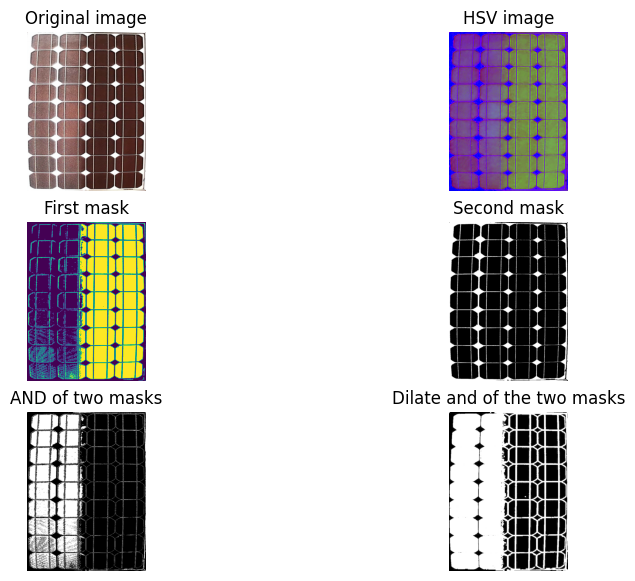

<Figure size 2000x700 with 0 Axes>

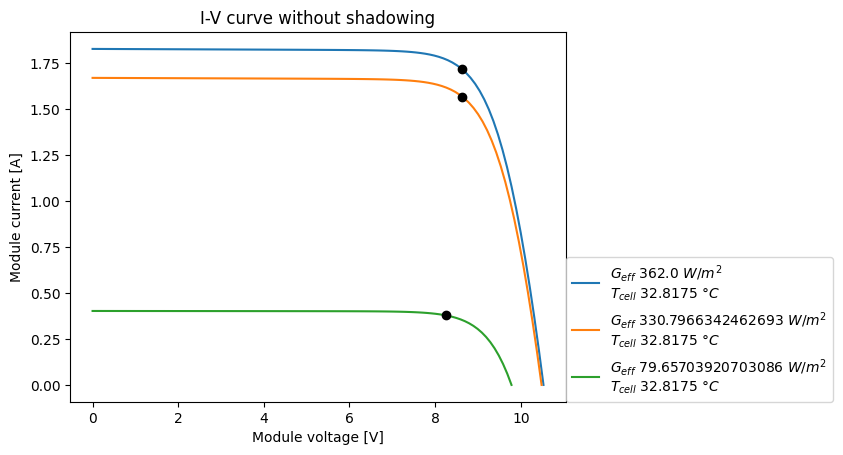

       i_sc       v_oc      i_mp      v_mp       p_mp
0  1.825952  10.530793  1.714501  8.635643  14.805819
1  1.668599  10.486314  1.567147  8.630366  13.525050
2  0.401879   9.783774  0.377422  8.262913   3.118608
merge_curves
first_point_second_curve 0.4018786886975079
0
1
voltage_to_start 10.168547070576592
curveto_to_plot_i, curveto_to_plot_v:  [1.66859869 1.66850691 1.66841513 1.66832335 1.66823157 1.66813979
 1.66804801 1.66795623 1.66786444 1.66777266 1.66768088 1.66758909
 1.66749731 1.66740552 1.66731373 1.66722194 1.66713015 1.66703835
 1.66694655 1.66685474 1.66676292 1.6666711  1.66657927 1.66648742
 1.66639556 1.66630367 1.66621176 1.66611982 1.66602785 1.66593582
 1.66584373 1.66575158 1.66565933 1.66556697 1.66547447 1.66538179
 1.66528891 1.66519576 1.66510228 1.66500839 1.664914   1.66481898
 1.66472319 1.66462644 1.6645285  1.66442908 1.66432784 1.66422434
 1.66411802 1.66400823 1.66389413 1.66377469 1.66364862 1.66351436
 1.66336993 1.66321291 1.66304028 1.66284831 

<Figure size 640x480 with 0 Axes>

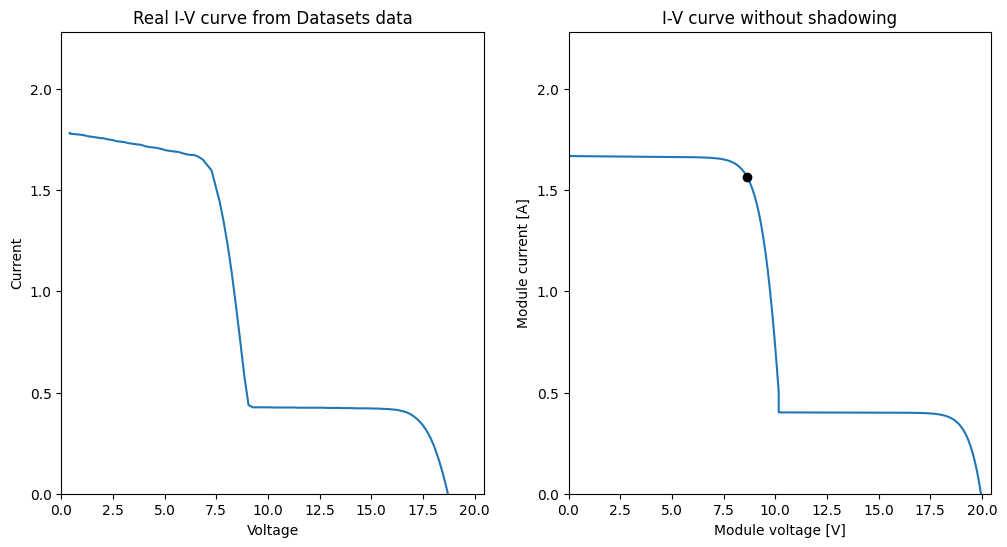

/content/drive/Shareddrives/RESM_Project/DEFINITIVO RESM/ANALISI ZONE D'OMBRA/ELABORATED_IMAGES/2021_24_09_15_44/
source_path + source_img:  /content/drive/Shareddrives/RESM_Project/DEFINITIVO RESM/ANALISI ZONE D'OMBRA/DATASET/Images_perspective/2021_24_09_15_44.jpg
width of the image:  600 height of the image:  800
Numero pixel bianchi per ogni sezione:  {1: 27536, 2: 16312, 3: 12074, 4: 12283}
Informazioni percentuale pixel soleggiati per ogni sezione:  {'first_string': {1: 0.3299700419412822, 2: 0.17206206554644896}, 'second_string': {3: 0.13043102517014152, 4: 0.13790741801116013}}
Percentuale pixels soleggiati su ciascuna delle due serie:  {'first_string': 0.24598744481158802, 'second_string': 0.13409712778784058}
Percentuale totale di pixel soleggiati: 18.95162410736614%
Percentuale di pixel neri nelle due sezioni:  {'first_string': 0.754012555188412, 'second_string': 0.8659028722121594}
count 401685
v_medio_neri 60.266268160324096 v_medio_bianchi 104.87595383223518
penalty facto

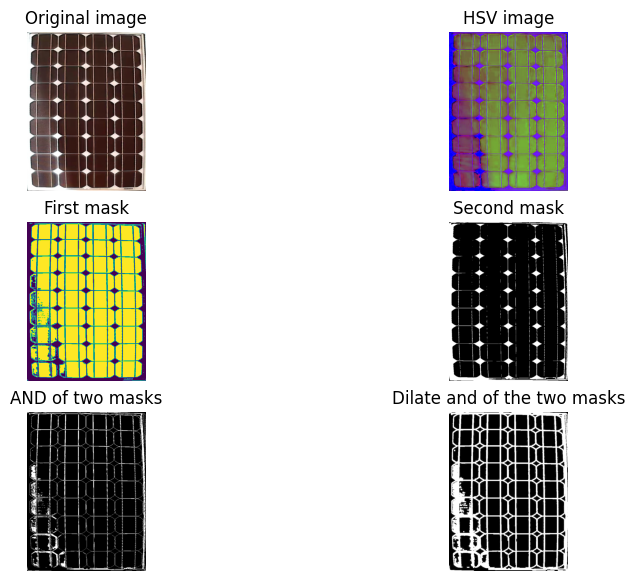

<Figure size 2000x700 with 0 Axes>

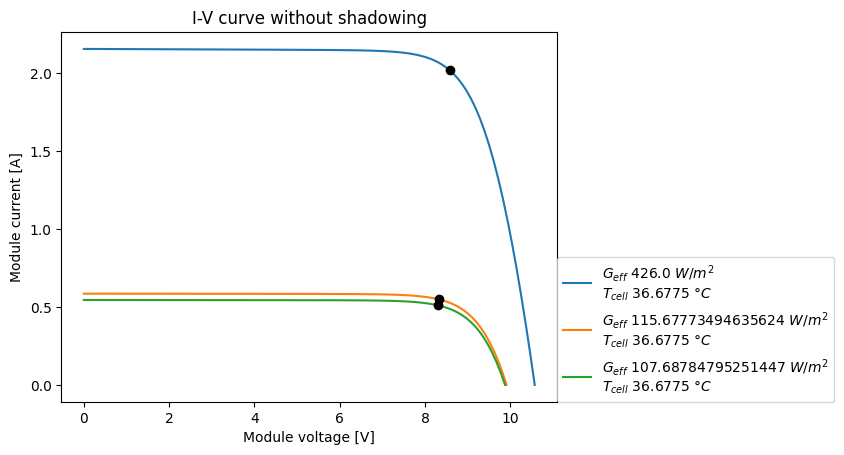

       i_sc       v_oc      i_mp      v_mp       p_mp
0  2.154014  10.573312  2.017615  8.577774  17.306643
1  0.585043   9.913726  0.548676  8.320390   4.565199
2  0.544637   9.877514  0.510737  8.295630   4.236882
merge_curves
first_point_second_curve 0.5446369256873606
0
1
voltage_to_start 8.311507535233275
curveto_to_plot_i, curveto_to_plot_v:  [0.58504277 0.58501242 0.58498207 0.58495173 0.58492138 0.58489103
 0.58486068 0.58483033 0.58479998 0.58476963 0.58473928 0.58470893
 0.58467858 0.58464823 0.58461787 0.58458752 0.58455716 0.5845268
 0.58449644 0.58446607 0.5844357  0.58440533 0.58437494 0.58434455
 0.58431416 0.58428374 0.58425332 0.58422288 0.58419242 0.58416193
 0.58413142 0.58410086 0.58407026 0.58403961 0.58400889 0.58397808
 0.58394718 0.58391615 0.58388498 0.58385362 0.58382205 0.58379021
 0.58375803 0.58372546 0.58369241 0.58365876 0.58362438 0.58358913
 0.5835528  0.58351517 0.58347594 0.58343476 0.58339122 0.58334479
 0.58329485 0.58324062 0.58318116 0.58311533 0.

<Figure size 640x480 with 0 Axes>

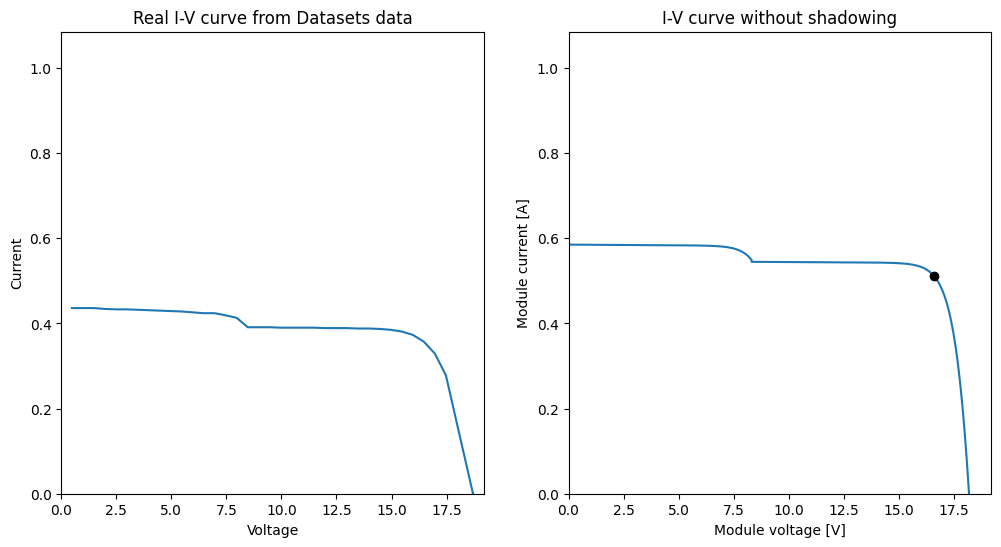

/content/drive/Shareddrives/RESM_Project/DEFINITIVO RESM/ANALISI ZONE D'OMBRA/ELABORATED_IMAGES/2020_17_04_14_37/
source_path + source_img:  /content/drive/Shareddrives/RESM_Project/DEFINITIVO RESM/ANALISI ZONE D'OMBRA/DATASET/Images_perspective/2020_17_04_14_37.jpg
width of the image:  600 height of the image:  800
Numero pixel bianchi per ogni sezione:  {1: 53428, 2: 58769, 3: 56581, 4: 63117}
Informazioni percentuale pixel soleggiati per ogni sezione:  {'first_string': {1: 0.6482564488339926, 2: 0.6849294313718635}, 'second_string': {3: 0.6714012791760113, 4: 0.7610601328783476}}
Percentuale pixels soleggiati su ciascuna delle due serie:  {'first_string': 0.66696191319752, 'second_string': 0.715871440020095}
Percentuale totale di pixel soleggiati: 69.1342676647974%
Percentuale di pixel neri nelle due sezioni:  {'first_string': 0.33303808680248004, 'second_string': 0.28412855997990505}
count 393219
v_medio_neri 80.33011332506705 v_medio_bianchi 114.41001860420081
penalty factor:  0.1

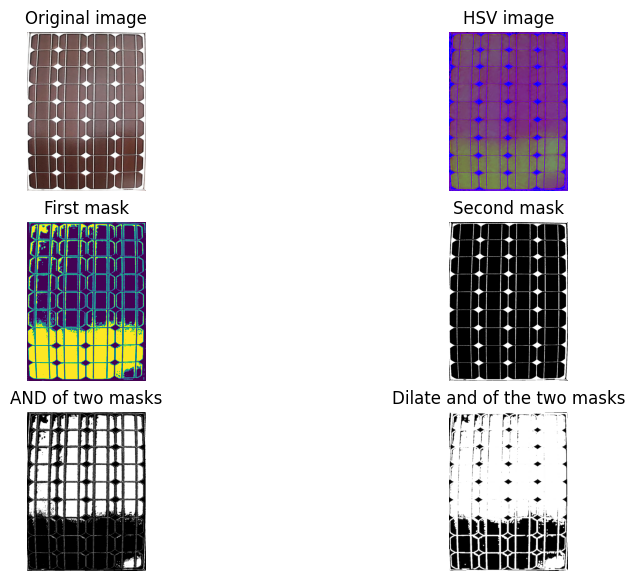

<Figure size 2000x700 with 0 Axes>

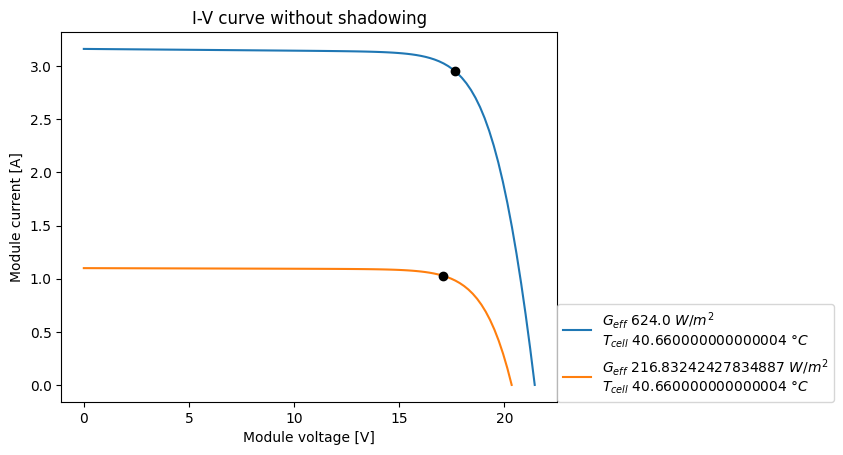

       i_sc       v_oc      i_mp       v_mp       p_mp
0  3.162791  21.449654  2.953522  17.660350  52.160227
1  1.099360  20.352659  1.026839  17.103829  17.562877
merge_curves
non ci sarà un merge delle curve perchè non è attivo il diodo di bypass
0
1


<Figure size 640x480 with 0 Axes>

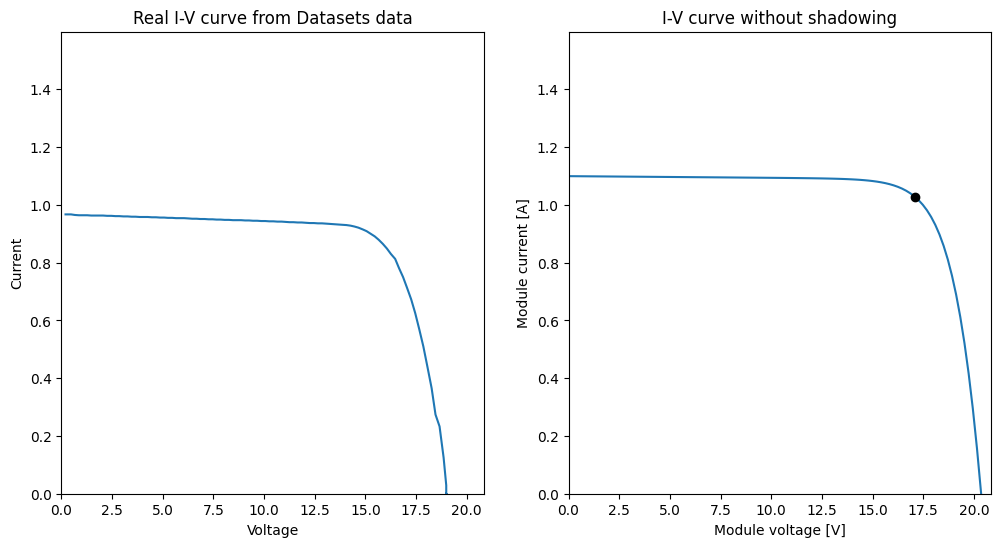

/content/drive/Shareddrives/RESM_Project/DEFINITIVO RESM/ANALISI ZONE D'OMBRA/ELABORATED_IMAGES/2020_22_03_17_53/
source_path + source_img:  /content/drive/Shareddrives/RESM_Project/DEFINITIVO RESM/ANALISI ZONE D'OMBRA/DATASET/Images_perspective/2020_22_03_17_53.jpg
width of the image:  600 height of the image:  800
Numero pixel bianchi per ogni sezione:  {1: 51832, 2: 50779, 3: 38513, 4: 37489}
Informazioni percentuale pixel soleggiati per ogni sezione:  {'first_string': {1: 0.6521060842433697, 2: 0.6049944598667986}, 'second_string': {3: 0.4602578964351016, 4: 0.45699901259249326}}
Percentuale pixels soleggiati su ciascuna delle due serie:  {'first_string': 0.6279089690791044, 'second_string': 0.45864462011948587}
Percentuale totale di pixel soleggiati: 54.26871693905392%
Percentuale di pixel neri nelle due sezioni:  {'first_string': 0.37209103092089557, 'second_string': 0.5413553798805142}
count 386974
v_medio_neri 86.3923528047447 v_medio_bianchi 134.13153357704738
penalty factor: 

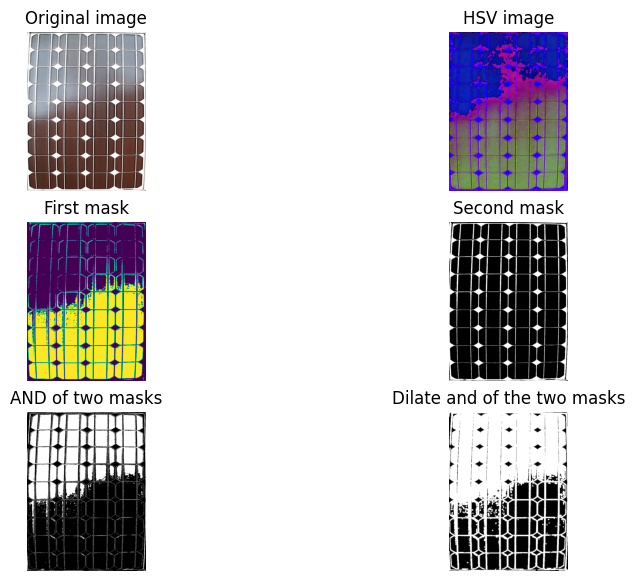

<Figure size 2000x700 with 0 Axes>

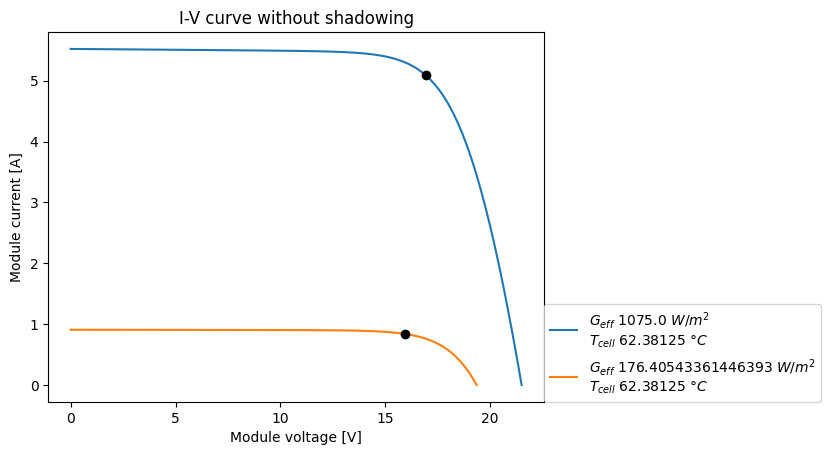

       i_sc       v_oc      i_mp       v_mp       p_mp
0  5.522745  21.505757  5.089214  16.934839  86.185010
1  0.906869  19.361632  0.836895  15.965606  13.361536
merge_curves
non ci sarà un merge delle curve perchè non è attivo il diodo di bypass
0
1


<Figure size 640x480 with 0 Axes>

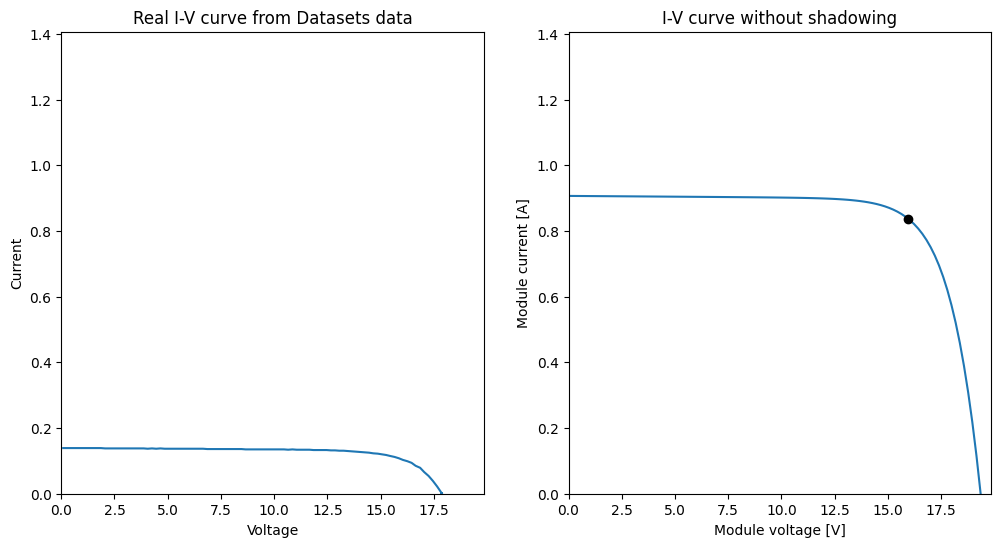

In [ ]:
images_to_analyze = ["2020_01_05_15_59.jpg", "2021_24_09_15_44.jpg", "2020_17_04_14_37.jpg", "2020_22_03_17_53.jpg"]
noct = 47  # NOCT (Temperature Coefficient of Open Circuit Voltage) in gradi Celsius
#quelle con bypass sono: 2020_01_05_15_59,2021_24_09_15_44 sono OK con errore inferiore di 0.20
#quelle senza bypass sono: 2020_17_04_14_37, 2020_22_03_17_53 l'errore sulla prima è molto piccolo mentre sulla seconda è di circa 0.75 però onestamente fa nulla
for image in images_to_analyze:
  #IMAGES ELABORATION STEPS, COMPUTATION OF SHADOWING PERCENTAGE AND PREDICTION OF PENALTY FACTOR DETERMINED BY THE PRESENCE OF SHADOW
  fig1 = plt.figure(figsize=(10, 7))
  detection_of_shadowing(image, fig1) #show and save all the required images to perform processing
  sun_pixels_string, total_sun_pixels = compute_total_sun_percentage(image) #obtain informations about the total number of sun pixels for each slice, for each string and for total panel
  #sun_pixels_string = compute_corrections(sun_pixels_string) #compute correction of the number of sun pixels for each strings
  shadow_pixels_string = compute_shadow_percentage(sun_pixels_string) #compute the shadowed pixels for each string
  v_medio_neri, v_medio_bianchi = compute_medium_brightness_values_blk_white(image) #compute the mean brightness value for black and white pixels respectively
  definitive_factor = definitive_factor_string(v_medio_neri, v_medio_bianchi, sun_pixels_string, shadow_pixels_string,total_sun_pixels) #obtain the definitive multiplicative factor to take into account the  presence of shadown on the panel

  #OBTAINING THE ORIGINAL I-V CURVE FROM VOLTAGE AND CURRENT PARAMETER MEASURED IN THE DATASET
  fig2 = plt.figure(figsize=(20, 7))
  file_name = "./ANALISI ZONE D'OMBRA/DATASET/Electrical_data/" + image.split('.')[0]+ ".txt"
  print(file_name)
  delimitator =  '\n'
  dati_file = leggi_file(file_name, delimitator) #read the true values in the file
  voltage, current, power = obtain_values_voltage_current_power(dati_file) #obtain the true values of voltage, current and power

  #OBTAINING THE PREDICTED I-V CURVE STARTING FROM THE SHADOWING ESTIMATION
  temperature, irradiance = obtain_temperature_irradiance(image)#for the image we are now analyzing it is necessary to obtain the temperature and irradiance value at which the acquisition has been made
  temperature = float(temperature)
  irradiance_mW_cm2 = float(irradiance) * 0.1
  print("irradiance_mW_cm2: ", irradiance_mW_cm2)
  print("temperature: ", temperature)
  # Calcola la temperatura della cella
  temperatura_cella = calcola_temperatura_cella(temperature, noct, irradiance_mW_cm2)
  print("Temperatura della cella:", temperatura_cella, "°C")

  data = set_base_parameters(definitive_factor, temperatura_cella) #compute the base parameters necessary to perform the analysis of pv
  parameters = calculate_parameters(data) #compute parameters for pv
  # temperature = 26.1
  # irradiance = 1075
  # pd.Series(np.array([parameters['temp_cell'], parameters['temp_cell']]))
  conditions, curve_info = parameters_and_cases_definitions(definitive_factor,parameters, float(temperatura_cella), float(irradiance))#now define the cases of interest and obtain the parameters necessary to design the curves
  plot_IV_characteristic(conditions,curve_info) #plot I-V curves

  create_final_plot(voltage, current, fig2, conditions,curve_info)
